Question #1
1.a: All three approaches are expected to give similar if not identical results in practice.
1.b: We cannot find which model will perform best on the test RSS, and will depend on the tradeoff between fitting to the data and overfitting.
1.c.i: True. Forward stepwise selection retains all features identified in previous models as k is increased.
1.c.ii: True. Backward stepwise selection removes features one by one as k is decreased.
1.c.iii: False. Forward and backward stepwise selection can identify different combinations of variables due to differing algorithms.
1.c.iv: False. Forward and backward stepwise selection can identify different combinations of variables due to differing algorithms.
1.c.v: False. Best subset selection can identify different combinations of variables for each k by considering all possible models.


In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV 
from sklearn.preprocessing import PolynomialFeatures, scale, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from itertools import combinations
from tqdm import tqdm

Question #8

In [3]:
np.random.seed(5)
# predictor X vector
x = np.random.randn(100, 1)
# noise vector
eps = np.random.randn(100, 1)

In [4]:
betas = [5, -10, 3, 14]

y = betas[0] + betas[1] * x + betas[2] * (x**2) + betas[3] * (x**3) + eps

In [5]:
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(x)

cols = ['x'+str(i) for i in range(1, 11)] + ['y']
X_df = pd.DataFrame(np.concatenate((X_poly,y), axis=1), columns=cols)
X_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.441227,0.194682,0.085899,0.037901,0.016723,0.007379,3.255652e-03,1.436483e-03,6.338158e-04,2.796569e-04,3.166778
1,-0.330870,0.109475,-0.036222,0.011985,-0.003965,0.001312,-4.341133e-04,1.436351e-04,-4.752458e-05,1.572447e-05,8.300783
2,2.430771,5.908649,14.362573,34.912128,84.863394,206.283494,5.014280e+02,1.218857e+03,2.962762e+03,7.201796e+03,197.740511
3,-0.252092,0.063550,-0.016021,0.004039,-0.001018,0.000257,-6.470160e-05,1.631076e-05,-4.111815e-06,1.036556e-06,8.117581
4,0.109610,0.012014,0.001317,0.000144,0.000016,0.000002,1.900846e-07,2.083514e-08,2.283736e-09,2.503200e-10,4.456710


In [8]:
def process_linear_model(subset, data, response):
    x_train = sm.add_constant(data[subset])
    model = sm.OLS(response, x_train).fit()
    train_RSS = model.ssr
    return (model, train_RSS)

def find_best_subset(data, response, max_features, operation):
    best_sub_list = []
    best_model = []
    num_of_features = []
    
    for k in tqdm(range(1, max_features+1)):
        best_rss = np.inf
        best_kth_model = None
        
        subsets = combinations(data.columns, k)
        
        for subset in subsets:
            result = process_linear_model(list(subset), data, response)
            if result[1] < best_rss:
                best_rss = result[1]
                best_subset = list(subset)
                best_kth_model = result[0]
                
        num_of_features.append(k)
        best_sub_list.append(best_subset)
        best_model.append(best_kth_model)
            
    results = pd.DataFrame({'sub': best_sub_list, 'model': best_model})
    results.to_pickle(f'./data/{operation}.pkl')
    return results

In [11]:
X = X_df.drop(['y'], axis=1)
y = X_df.y

bestsub_results = find_best_subset(X, y, 10, 'poly_bestsub')

100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


In [12]:
# best subset selection results
bestsub_results

,sub,model
0,[x3],<statsmodels.regression.linear_model.Regressio...
1,"[x5, x7]",<statsmodels.regression.linear_model.Regressio...
2,"[x1, x2, x3]",<statsmodels.regression.linear_model.Regressio...
3,"[x1, x2, x3, x5]",<statsmodels.regression.linear_model.Regressio...
4,"[x1, x2, x3, x7, x10]",<statsmodels.regression.linear_model.Regressio...
5,"[x1, x2, x3, x5, x7, x9]",<statsmodels.regression.linear_model.Regressio...
6,"[x1, x2, x3, x5, x6, x7, x9]",<statsmodels.regression.linear_model.Regressio...
7,"[x1, x2, x3, x5, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
8,"[x1, x2, x3, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
9,"[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...


In [13]:
aic = [bestsub_results.model[i].aic for i in range(0, len(bestsub_results.model))]
bic = [bestsub_results.model[i].bic for i in range(0, len(bestsub_results.model))]
r2_adj = [bestsub_results.model[i].rsquared_adj for i in range(0, len(bestsub_results.model))]
rss = [bestsub_results.model[i].ssr for i in range(0, len(bestsub_results.model))]

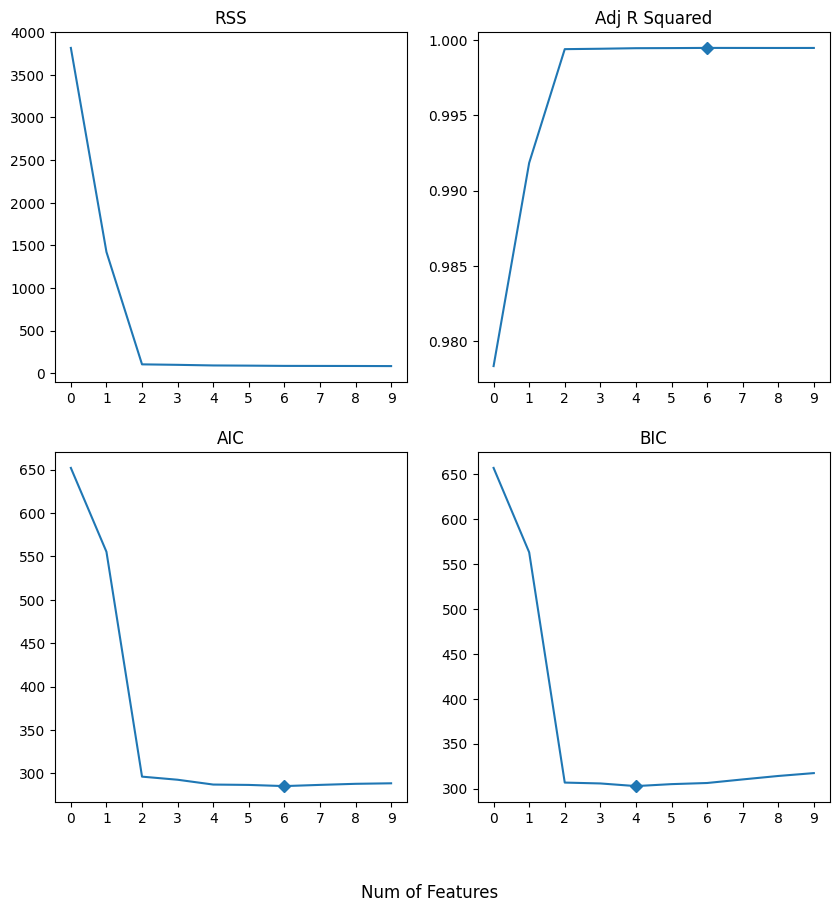

In [14]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

axes[0, 0].plot(rss)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj, markevery=[np.argmax(r2_adj)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic, markevery=[np.argmin(aic)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic, markevery=[np.argmin(bic)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

In [16]:
# Coefficient estimates for best model obtained acc.to BIC
bestsub_results.model[4].params


const     4.947337
x1      -10.429378
x2        3.073473
x3       14.450429
x7       -0.011511
x10      -0.000260
dtype: float64

In [17]:
# Coefficient estimates for best model obtained acc.to AIC and Adjusted R2
bestsub_results.model[6].params

const     5.068818
x1       -9.646528
x2        2.789910
x3       12.042326
x5        1.870729
x6        0.033739
x7       -0.504306
x9        0.038531
dtype: float64

In [18]:
def forward_stepwise(X, y, max_features):
    models = []
    feature_list = []
    remaining_features = list(X.columns)
    
    def update_model(current_features, remaining_features):
        best_rss = np.inf
        best_model = None
        
        for new_feature in tqdm(remaining_features):
            result = process_linear_model(feature_list + [new_feature], X, y)
            if result[1] < best_rss:
                best_rss = result[1]
                best_model = result[0]

        new_feature_list = list(best_model.params.index)[1:]
        
        return new_feature_list, best_model
    
    while remaining_features and len(feature_list) < max_features:
        feature_list, best_model = update_model(feature_list, remaining_features)
        remaining_features = [x for x in list(X.columns) if x not in feature_list]
        models.append([feature_list, best_model])
        
    return models

bestsub_forward = forward_stepwise(X, y, 10)

100%|██████████| 1/1 [00:00<00:00, 333.17it/s]


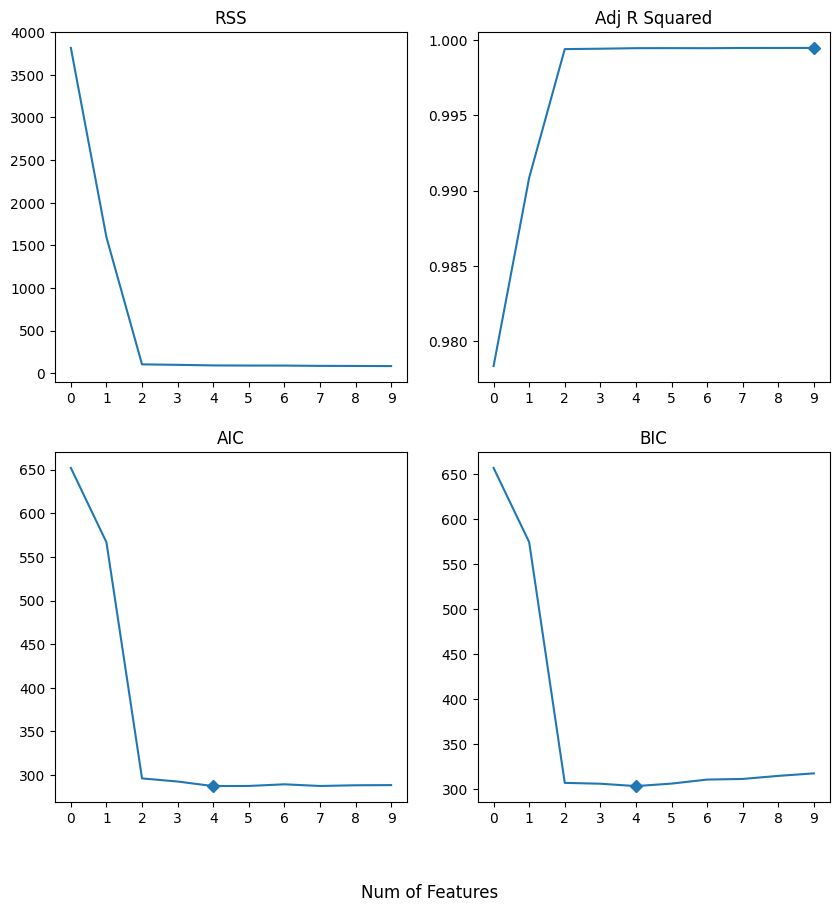

In [19]:
aic_fwd = [model[1].aic for model in bestsub_forward]
bic_fwd = [model[1].bic for model in bestsub_forward] 
r2_adj_fwd = [model[1].rsquared_adj for model in bestsub_forward]
rss_fwd = [model[1].ssr for model in bestsub_forward]

fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

axes[0, 0].plot(rss_fwd)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj_fwd, markevery=[np.argmax(r2_adj_fwd)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic_fwd, markevery=[np.argmin(aic_fwd)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic_fwd, markevery=[np.argmin(bic_fwd)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

In [ ]:
print('4-variable model parameter acc.t. forward stepwise: ', bestsub_forward[4][0])
print('9-variable model parameter acc.t. forward stepwise: ', bestsub_forward[9][0])

In [21]:
def backward_stepwise(X, y, min_feature):
    models = []
    feature_list = list(X.columns)
    
    def update_model(feature_list):
        best_rss = np.inf
        best_model = None
        best_feature_list = []
        
        for feature in tqdm(feature_list):
            new_feature_list = [x for x in feature_list if x != feature]
            
            result = process_linear_model(new_feature_list, X, y)
            if result[1] < best_rss:
                best_rss = result[1]
                best_model = result[0]
        
        best_feature_list = list(best_model.params.index)[1:]
        return best_feature_list, best_model
    
    while len(feature_list) >= min_feature:
        best_feature_list, best_model = update_model(feature_list)
        feature_list = best_feature_list
        models.append([feature_list, best_model])
    
    return models

bestsub_backward = backward_stepwise(X, y, 1)

100%|██████████| 1/1 [00:00<00:00, 67.07it/s]


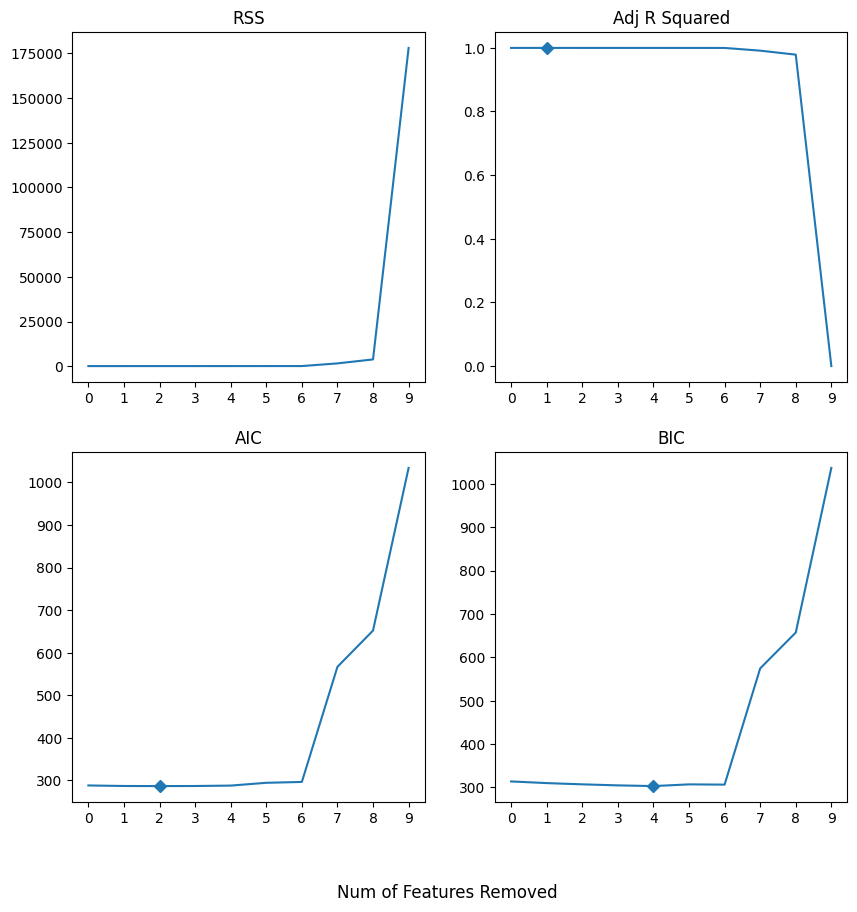

In [22]:
aic_back = [model[1].aic for model in bestsub_backward]
bic_back = [model[1].bic for model in bestsub_backward] 
r2_adj_back = [model[1].rsquared_adj for model in bestsub_backward]
rss_back = [model[1].ssr for model in bestsub_backward]

fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features Removed')

axes[0, 0].plot(rss_back)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj_back, markevery=[np.argmax(r2_adj_back)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic_back, markevery=[np.argmin(aic_back)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic_back, markevery=[np.argmin(bic_back)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

In [23]:
print('8-variable model parameter acc.t. backward stepwise: ', bestsub_backward[1][0])
print('7-variable model parameter acc.t. backward stepwise: ', bestsub_backward[2][0])
print('5-variable model parameter acc.t. backward stepwise: ', bestsub_backward[4][0])

alphas = np.logspace(-4, -1, 100)
lassocv = LassoCV(alphas=alphas, cv=5, max_iter=100000)

lassocv.fit(scale(X), y)

8-variable model parameter acc.t. backward stepwise:  ['x1', 'x2', 'x3', 'x5', 'x7', 'x8', 'x9', 'x10']
7-variable model parameter acc.t. backward stepwise:  ['x1', 'x2', 'x3', 'x5', 'x7', 'x8', 'x9']
5-variable model parameter acc.t. backward stepwise:  ['x1', 'x2', 'x3', 'x7', 'x9']


,eps,0.001
,n_alphas,'deprecated'
,alphas,"array([0.0001..., 0.1 ])"
,fit_intercept,True
,precompute,'auto'
,max_iter,100000
,tol,0.0001
,copy_X,True
,cv,5
,verbose,False
,n_jobs,None


In [24]:
# optimal value of alpha
lassocv.alpha_

np.float64(0.061359072734131756)

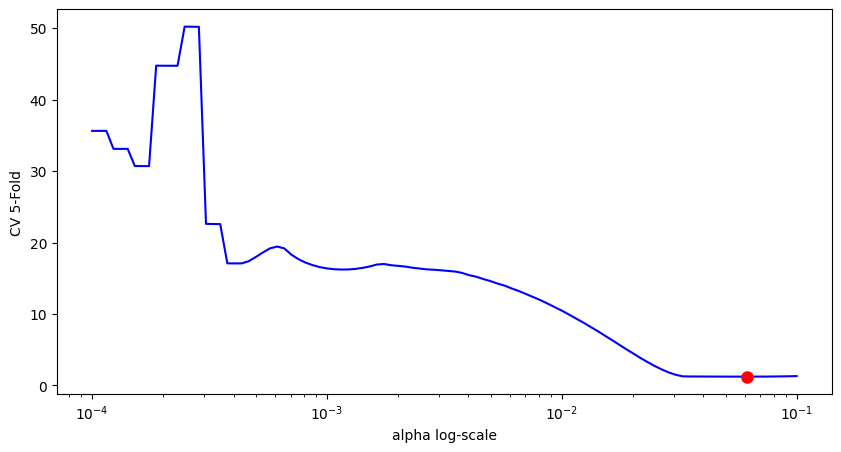

In [25]:
mses = np.mean(lassocv.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lassocv.alphas_,mses, color='b');
ax.plot(lassocv.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('CV 5-Fold');

In [ ]:
pd.Series(lassocv.coef_.flatten(), index=X.columns) 

x1     -8.818816
x2      3.878525
x3     48.509026
x4      0.000000
x5      0.000000
x6     -0.000000
x7      0.000000
x8     -0.000000
x9      0.000000
x10    -0.000000
dtype: float64

In [27]:
y2 = -4 + 7.25 * (x**7) + eps

In [28]:
bestsub2 = find_best_subset(X, y2, 10, 'poly_bestsub_2')
bestsub2

100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


,sub,model
0,[x7],<statsmodels.regression.linear_model.Regressio...
1,"[x3, x7]",<statsmodels.regression.linear_model.Regressio...
2,"[x5, x7, x9]",<statsmodels.regression.linear_model.Regressio...
3,"[x3, x5, x7, x9]",<statsmodels.regression.linear_model.Regressio...
4,"[x3, x5, x6, x7, x9]",<statsmodels.regression.linear_model.Regressio...
5,"[x2, x3, x4, x5, x7, x9]",<statsmodels.regression.linear_model.Regressio...
6,"[x3, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
7,"[x1, x3, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
8,"[x2, x3, x4, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...
9,"[x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]",<statsmodels.regression.linear_model.Regressio...


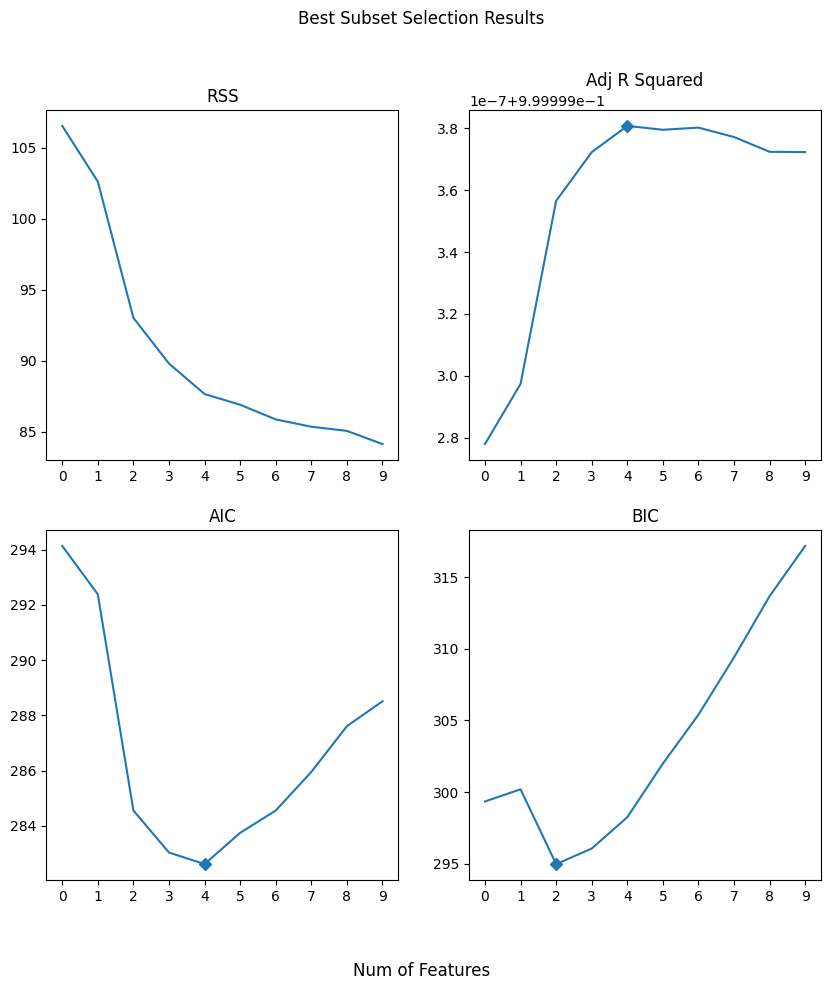

In [29]:
aic2 = [bestsub2.model[i].aic for i in range(0, len(bestsub2.model))]
bic2 = [bestsub2.model[i].bic for i in range(0, len(bestsub2.model))]
r2_adj2 = [bestsub2.model[i].rsquared_adj for i in range(0, len(bestsub2.model))]
rss2 = [bestsub2.model[i].ssr for i in range(0, len(bestsub2.model))]

fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

fig.suptitle('Best Subset Selection Results')

axes[0, 0].plot(rss2)
axes[0, 0].set_title('RSS')
axes[0, 0].set_xticks(np.arange(0, 10, 1))

axes[0, 1].plot(r2_adj2, markevery=[np.argmax(r2_adj2)], marker='D')
axes[0, 1].set_title('Adj R Squared')
axes[0, 1].set_xticks(np.arange(0, 10, 1))

axes[1, 0].plot(aic2, markevery=[np.argmin(aic2)], marker='D')
axes[1, 0].set_title('AIC')
axes[1, 0].set_xticks(np.arange(0, 10, 1))

axes[1, 1].plot(bic2, markevery=[np.argmin(bic2)], marker='D')
axes[1, 1].set_title('BIC')
axes[1, 1].set_xticks(np.arange(0, 10, 1))

In [30]:
np.random.seed(5)
lassocv2 = LassoCV(n_alphas=400, cv=10, max_iter=10000)

lassocv2.fit(scale(X), y2.ravel())

# optimal value of alpha
lassocv2.alpha_

C:\Users\anujb\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


np.float64(1.2210192922875793)

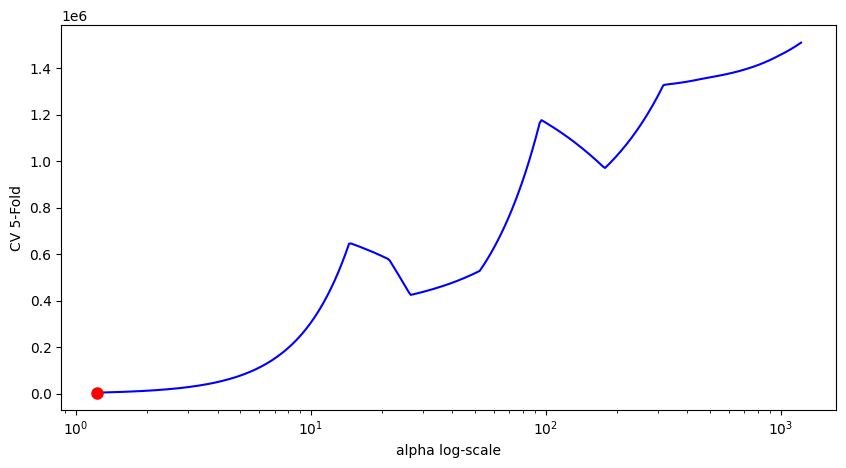

In [31]:
mses = np.mean(lassocv2.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(10,5));
ax.plot(lassocv2.alphas_,mses, color='b');
ax.plot(lassocv2.alpha_, np.min(mses), marker='o', color='r', markersize=8);
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('CV 5-Fold');

In [32]:
# Coefficient estimates of lasso model
pd.Series(lassocv2.coef_.flatten(), index=X.columns)

x1       -0.000000
x2        0.000000
x3        0.000000
x4        0.000000
x5       59.222959
x6        0.000000
x7     1069.219682
x8       -0.000000
x9       93.073638
x10      -0.000000
dtype: float64

end of question #8

In [33]:
import pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv("train.csv")

# Drop the 'id' column
df = df.drop(columns=['id'])

# Define features and target
X = df.drop(columns=['Rings'])
y = df['Rings']

# Identify categorical and numerical columns
categorical_features = ['Sex']
numerical_features = X.drop(columns=categorical_features).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regression with cross-validation
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5))
])
ridge_pipeline.fit(X_train, y_train)
ridge_preds = ridge_pipeline.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

# Lasso Regression with cross-validation
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(alphas=[0.1, 1.0, 10.0], cv=5, max_iter=10000))
])
lasso_pipeline.fit(X_train, y_train)
lasso_preds = lasso_pipeline.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_r2 = r2_score(y_test, lasso_preds)

# Print performance metrics
print("Ridge Regression:")
print(f"  MSE: {ridge_mse:.4f}")
print(f"  R²: {ridge_r2:.4f}")

print("\nLasso Regression:")
print(f"  MSE: {lasso_mse:.4f}")
print(f"  R²: {lasso_r2:.4f}")


Ridge Regression:
  MSE: 4.0953
  R²: 0.6013

Lasso Regression:
  MSE: 4.4996
  R²: 0.5620


In [57]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv("train.csv")

# Drop the 'id' column
df = df.drop(columns=['id'])

# Define features and target
X = df.drop(columns=['Rings'])
y = df['Rings']

# Identify categorical and numerical columns
categorical_features = ['Sex']
numerical_features = X.drop(columns=categorical_features).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Principal Components Regression pipeline with n_components=9
pcr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=9)),
    ('regressor', LinearRegression())
])

# Fit the model
pcr_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pcr_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print("Principal Components Regression:")
print(f"  MSE: {mse:.4f}")
print(f"  R²: {r2:.4f}")


Principal Components Regression:
  MSE: 4.0953
  R²: 0.6013


In [75]:
test_data = pd.read_csv("./test.csv")
test_preds = lasso_pipeline.predict(test_data)

In [76]:
#Create a submission file in the required format:
submission = pd.DataFrame({'id': test_data['id'], 'Rings': test_preds})
submission.to_csv('submission.csv', index=False)


In [37]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load and prepare the dataset
df = pd.read_csv("train.csv")
df = df.drop(columns=['id'])
X = df.drop(columns=['Rings'])
y = df['Rings']

# Identify feature types
categorical_features = ['Sex']
numerical_features = X.drop(columns=categorical_features).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regression
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5))
])
ridge_pipeline.fit(X_train, y_train)
ridge_preds = ridge_pipeline.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

# Lasso Regression
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(alphas=[0.1, 1.0, 10.0], cv=5, max_iter=10000))
])
lasso_pipeline.fit(X_train, y_train)
lasso_preds = lasso_pipeline.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_r2 = r2_score(y_test, lasso_preds)

# Principal Components Regression
pcr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=9)),
    ('regressor', LinearRegression())
])
pcr_pipeline.fit(X_train, y_train)
pcr_preds = pcr_pipeline.predict(X_test)
pcr_mse = mean_squared_error(y_test, pcr_preds)
pcr_r2 = r2_score(y_test, pcr_preds)

# Scatter plot: Predicted vs Actual
fig_scatter = go.Figure()
fig_scatter.add_trace(go.Scatter(x=y_test, y=ridge_preds, mode='markers', name='Ridge'))
fig_scatter.add_trace(go.Scatter(x=y_test, y=lasso_preds, mode='markers', name='Lasso'))
fig_scatter.add_trace(go.Scatter(x=y_test, y=pcr_preds, mode='markers', name='PCR'))
fig_scatter.update_layout(title='Predicted vs Actual Values',
                          xaxis_title='Actual Rings',
                          yaxis_title='Predicted Rings')

# Bar chart: MSE and R² comparison
metrics_df = pd.DataFrame({
    'Model': ['Ridge', 'Lasso', 'PCR'],
    'MSE': [ridge_mse, lasso_mse, pcr_mse],
    'R2': [ridge_r2, lasso_r2, pcr_r2]
})

fig_bar = px.bar(metrics_df.melt(id_vars='Model'), x='Model', y='value',
                 color='variable', barmode='group',
                 title='Model Performance Comparison',
                 labels={'value': 'Score', 'variable': 'Metric'})

# Show plots

fig_bar.show()


In [39]:
import pandas as pd
import plotly.express as px

# Load the dataset
df = pd.read_csv("train.csv")

# Drop non-numeric columns
numeric_df = df.drop(columns=['id', 'Sex'])  # 'Sex' is categorical

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Generate a heatmap using Plotly
fig = px.imshow(correlation_matrix,
                text_auto=True,
                color_continuous_scale='RdBu',
                title='Correlation Matrix Heatmap of Numerical Features')

# Show the plot
fig.show()


In [36]:
!pip install plotly


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 9.6/9.6 MB 64.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
